# Overview

* Với các bài toán biến đổi homography thì ta sẽ cần 1 ảnh **nguồn** và 1 ảnh **đích**
* Đề bài yêu cầu chuyển bức ảnh sân tennis thành ảnh mới với **góc nhìn từ trên xuống**.
### => Khi đó ta cần tìm ảnh đích - ở đây chính là bird-eye-view image .

In [37]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt


(np.float64(-0.5), np.float64(599.5), np.float64(349.5), np.float64(-0.5))

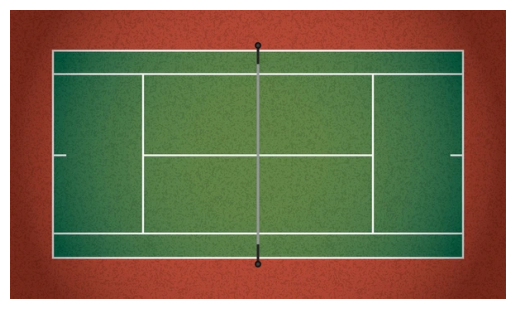

In [24]:
%matplotlib inline

dst = cv2.imread('images/tennis_bird_view.jpg', -1)
dst_copy = dst.copy()

# Chuyển đổi ảnh từ BGR sang RGB để hiển thị đúng màu
dst_rgb = cv2.cvtColor(dst_copy, cv2.COLOR_BGR2RGB)

plt.imshow(dst_rgb)
plt.axis('off')

Ảnh hiển thị ở trên chính là ảnh bird-eye-view của 1 sân tennis , ta có thể dễ dàng tìm ảnh này khi search ở trên mạng.
* Thông thường , nếu có thể thì nên tìm bird-eye-view của chính cái sân mà mình cần biến đổi , khi đó  kết quả cuối cùng nhìn sẽ trực quan hơn.

# Solution

Trước hết ta cần đọc các 2 ảnh cần dùng

In [27]:
# ---- Load images ----
src = cv2.imread('images/tennis.jpg')           # Ảnh đích
dst = cv2.imread('images/tennis_bird_view.jpg') # Ảnh nguồn

# BGR -> RGB đ
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

Để giải quyết bài toán này thì đầu tiên ta cần tìm ra phép biến đổi ở đây là gì.

=> Ta sẽ cần dùng tới hàm **cv2.findHomography()** của opencv.
Chi tiết hàm có thể đọc ở [link](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780) này

Hàm này sẽ trả về :
* H → Ma trận homography 3x3:$$  H = \begin{bmatrix} h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33} \end{bmatrix}$$

* mask → Mặt nạ nhị phân xác định inlier/outlier (chỉ có nếu dùng RANSAC/LMEDS/RHO).

Hàm tìm ma trận $H$ sao cho mọi cặp điểm tương ứng thỏa mãn gần đúng:$$s_i \begin{bmatrix} x'_i \\ y'_i \\ 1 \end{bmatrix} \approx H \begin{bmatrix} x_i \\ y_i \\ 1 \end{bmatrix}$$trong đó:
* $(x_i, y_i)$ là điểm gốc trong ảnh nguồn.
* $(x'_i, y'_i)$ là điểm tương ứng trong ảnh đích.$s_i$ là hệ số tỉ lệ (vì phép biến đổi là đồng nhất).

**NOTE**:
 Vì H có kích cỡ 3x3 => có 9 ẩn số.
Tuy nhiên, vì phép biến đổi phối cảnh chỉ xác định tới một hệ số tỉ lệ (scale), ta có thể chia toàn bộ H cho h₃₃, và giả sử h₃₃ =1

-> Chỉ có 8 ẩn số cần tìm .

=> Ta sẽ cần 4 cặp điểm. Ta sẽ cần viết hàm để lấy giá trị các điểm mà ta chọn thủ công .


In [30]:
src_points = []
dst_points = []

def get_points(image, title="Select points", num_points=4):
    print(f"Chọn {num_points} điểm trên ảnh {title}. Click chuột trái để chọn, đóng cửa sổ khi xong.")
    plt.imshow(image)
    pts = plt.ginput(num_points, timeout=0)  # Chờ người dùng click 4 lần
    plt.close()
    pts = np.array(pts, dtype=np.float32)
    print(f"Đã chọn: {pts}")
    return pts

Sau khi có ma trận H rồi thì ta sẽ dùng tới hàm **warpPerspective()** .
Hàm này áp dụng phép biến đổi phối cảnh cho một ảnh, dựa trên ma trận biến đổi H đã tìm được.
* Chi tiết hàm ở [link](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87) này.

In [34]:
def get_plan_view(src, dst, src_pts, dst_pts):
    H, mask = cv2.findHomography(src_pts, dst_pts,method=  cv2.RANSAC, ransacReprojThreshold= 5.0)
    print("Ma trận Homography H:")
    print(H)
    plan_view = cv2.warpPerspective(src, H, dsize = (dst.shape[1], dst.shape[0]))
    return plan_view # ảnh output

Giờ ta sẽ ghép:
* Ảnh đã qua biến đổi homography ( plan_view )
* Ảnh đích

In [35]:
# ---- Hàm ghép ảnh ----
def merge_views(src, dst, src_pts, dst_pts):
    plan_view = get_plan_view(src, dst, src_pts, dst_pts)
    mask = np.all(plan_view == 0, axis=-1)
    result = plan_view.copy()
    result[mask] = dst[mask]
    return result  # Ảnh kết quả mà mình cần

Sau khi có hết các hàm cần thiết thì ta chỉ việc chạy đoạn code dưới đây.
* Hãy chọn  4 cặp điểm làm mốc của ảnh gốc và ảnh đích. Để chính xác nhất thì nên chọn 4 góc của sân.

In [43]:
%matplotlib tk
# ---- Chạy chọn điểm ----
src_pts = get_points(src, "SRC", 4)
dst_pts = get_points(dst, "DST", 4)

# ---- Tính & hiển thị kết quả ----
plan_view = get_plan_view(src, dst, src_pts, dst_pts)
merge = merge_views(src, dst, src_pts, dst_pts)

# Hiển thị kết quả
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Ảnh nguồn (SRC)")
plt.imshow(src)
plt.subplot(1,3,2)
plt.title("Ảnh đích (DST)")
plt.imshow(dst)
plt.subplot(1,3,3)
plt.title("Ảnh sau ghép (Merged)")
plt.imshow(merge)
plt.show()


Chọn 4 điểm trên ảnh SRC. Click chuột trái để chọn, đóng cửa sổ khi xong.
Đã chọn: [[119.258064  42.319355]
 [456.9758    41.52097 ]
 [583.121    359.27902 ]
 [  5.08871  356.88388 ]]
Chọn 4 điểm trên ảnh DST. Click chuột trái để chọn, đóng cửa sổ khi xong.
Đã chọn: [[545.4677    48.20968 ]
 [545.4677   295.7903  ]
 [ 50.30645  297.40323 ]
 [ 51.919353  47.403225]]
Ma trận Homography H:
[[ 2.85503772e-03 -1.60687740e+00  6.70458908e+02]
 [ 8.14721811e-01  4.07886533e-01 -6.11470358e+01]
 [ 1.79499911e-05  2.43295701e-03  1.00000000e+00]]
Ma trận Homography H:
[[ 2.85503772e-03 -1.60687740e+00  6.70458908e+02]
 [ 8.14721811e-01  4.07886533e-01 -6.11470358e+01]
 [ 1.79499911e-05  2.43295701e-03  1.00000000e+00]]


## NOTE : *TƯƠNG TỰ VỚI ẢNH CÒN LẠI*

**CÁCH NÀY BẠN CÓ THỂ MỞ RỘNG RA VỚI CÁC TRƯỜNG HỢP KHÁC NHƯ SÂN BÓNG ĐÁ , BÓNG CHUYỀN ,...**